**ARTIST IDENTIFICATION FROM ART using CNN**

Import **"best-artworks-of-all-time"** dataset from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bananatoffee","key":"a00e01e607f122d4e903b525091d1581"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [00:30<00:00, 53.6MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.6MB/s]


In [ ]:
! unzip best-artworks-of-all-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflat

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import *
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import *

In [ ]:
print(os.listdir("/content/images"))
print(os.listdir("/content/resized"))

['images']
['resized']


Read data - **"artists.csv"**

In [ ]:
artists = pd.read_csv("artists.csv")

Shape of **"artists"** dataset

In [ ]:
artists.shape

(50, 8)

In [ ]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


Check for missing values

In [ ]:
artistsMissingValues = artists.isnull().sum()
artistsMissingValues

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64

Relationship between artist's **"name"** and **"nationality"**

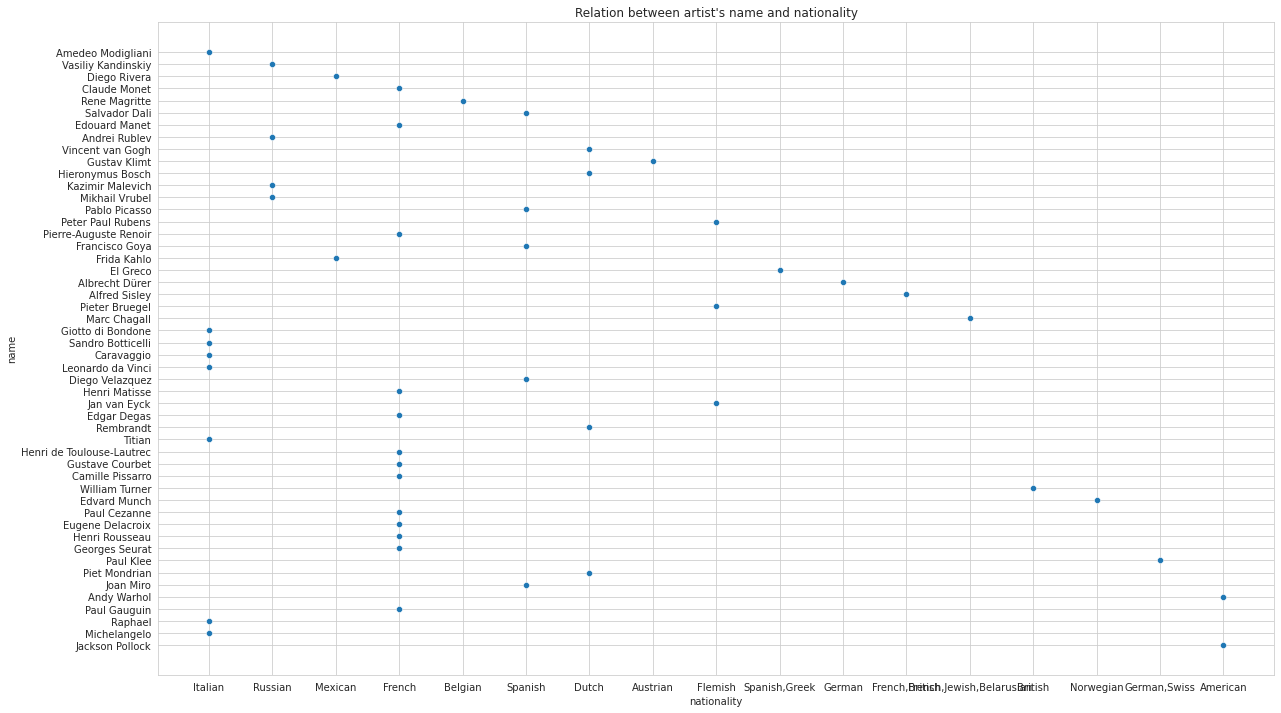

In [ ]:
plt.figure(figsize=(20,12))
sns.set_style("whitegrid")
plt.title("Relation between artist's name and nationality")
ax = sns.scatterplot(x="nationality", y="name", data=artists, palette="coolwarm")

Distribution of number of **"paintings"**

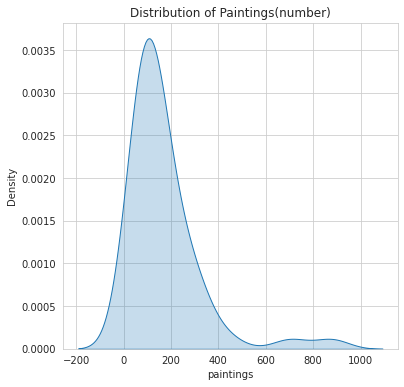

In [ ]:
plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.title("Distribution of Paintings(number)")
ax = sns.kdeplot(data=artists["paintings"], shade=True, palette="coolwarm")

Scatterplot to show artist's  **"name"** and number of **"paintings"** per artist

> We are only considering the artists with number of paintings over 200


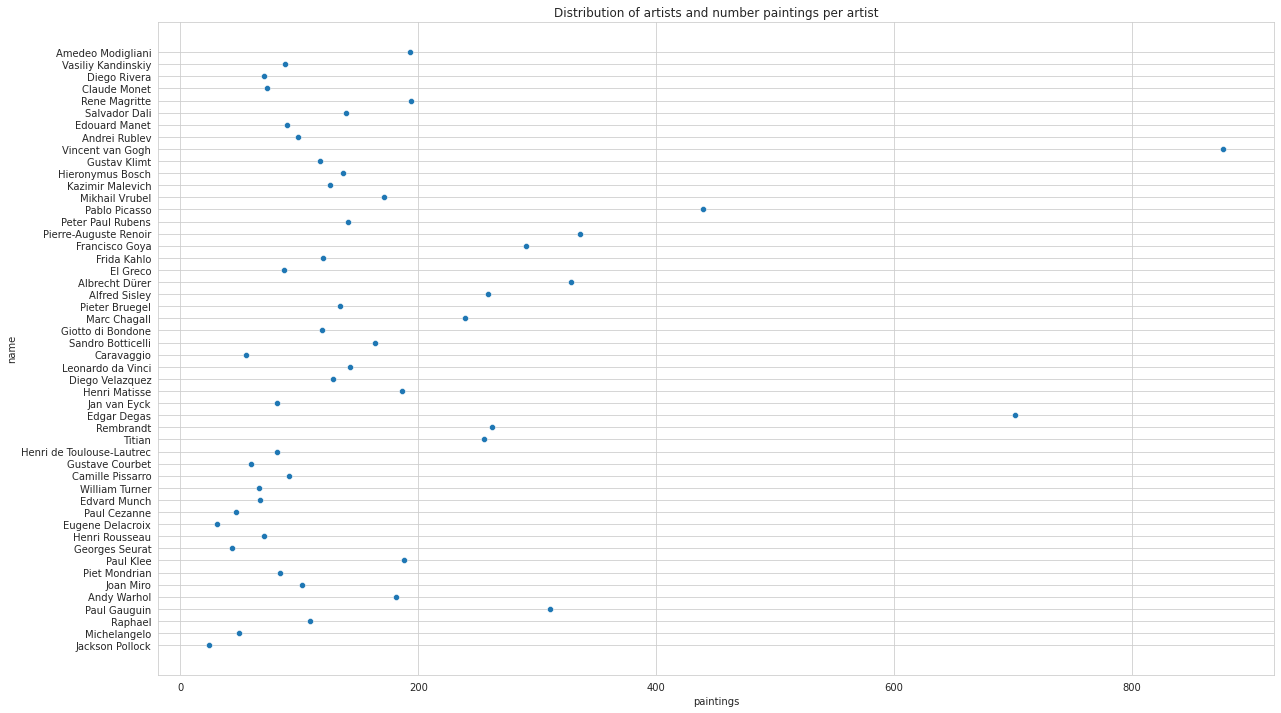

In [ ]:
plt.figure(figsize=(20,12))
sns.set_style("whitegrid")
plt.title("Distribution of artists and number paintings per artist")
ax = sns.scatterplot(x="paintings", y="name", data=artists, palette="coolwarm")

Sort artists by **"paintings"** in descending order

In [ ]:
artists = artists.sort_values(by=["paintings"], ascending=False)
artists

,id,name,years,genre,nationality,bio,wikipedia,paintings
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
15,15,Pierre-Auguste Renoir,1841 - 1919,Impressionism,French,"Pierre-Auguste Renoir, commonly known as Augus...",http://en.wikipedia.org/wiki/Pierre-Auguste_Re...,336
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
46,46,Paul Gauguin,1848 – 1903,"Symbolism,Post-Impressionism",French,"Eugène Henri Paul Gauguin (UK: , US: ; French:...",http://en.wikipedia.org/wiki/Paul_Gauguin,311
16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
20,20,Alfred Sisley,1839 - 1899,Impressionism,"French,British",Alfred Sisley (; French: [sislɛ]; 30 October 1...,http://en.wikipedia.org/wiki/Alfred_Sisley,259
32,32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


Dropping **"Albrecht Dürer"** due to his name not being recognized

In [ ]:
artists = artists.drop(labels=19, axis=0)

Select only artists with **"paintings"** >= 200 from **"artists"** into **"topArtists"** and add column **"class_weights"**

In [ ]:
topArtists = artists[artists["paintings"] >= 200].reset_index()
topArtists = topArtists[["name", "paintings"]]
topArtists["class_weights"] = topArtists.paintings.sum() / (topArtists.shape[0]*topArtists.paintings)
topArtists.drop(4)
topArtists

,name,paintings,class_weights
0,Vincent van Gogh,877,0.452794
1,Edgar Degas,702,0.565670
2,Pablo Picasso,439,0.904556
3,Pierre-Auguste Renoir,336,1.181845
4,Paul Gauguin,311,1.276849
5,Francisco Goya,291,1.364605
6,Rembrandt,262,1.515649
7,Alfred Sisley,259,1.533205
8,Titian,255,1.557255
9,Marc Chagall,239,1.661506


In [ ]:
topArtistsName = topArtists['name'].str.replace(' ', '_').values

In [ ]:
classWeights = topArtists["class_weights"].to_dict()
classWeights

{0: 0.45279361459521095,
 1: 0.5656695156695156,
 2: 0.9045558086560365,
 3: 1.181845238095238,
 4: 1.2768488745980708,
 5: 1.3646048109965636,
 6: 1.515648854961832,
 7: 1.5332046332046332,
 8: 1.5572549019607844,
 9: 1.6615062761506276}

Here we remove the folders/directories that are not a part of **"topArtists"** with the exception of **"Albrecht Dürer"** whose name is not being recognized

In [ ]:
import shutil
shutil.rmtree('/content/resized')
shutil.rmtree('/content/images/images/Albrecht_DuтХа├кrer')
shutil.rmtree('/content/images/images/Albrecht_Du╠Иrer')
shutil.rmtree('/content/images/images/Amedeo_Modigliani')
shutil.rmtree('/content/images/images/Andrei_Rublev')
shutil.rmtree('/content/images/images/Andy_Warhol')
shutil.rmtree('/content/images/images/Camille_Pissarro')
shutil.rmtree('/content/images/images/Caravaggio')
shutil.rmtree('/content/images/images/Claude_Monet')
shutil.rmtree('/content/images/images/Diego_Rivera')
shutil.rmtree('/content/images/images/Diego_Velazquez')
shutil.rmtree('/content/images/images/Edouard_Manet')
shutil.rmtree('/content/images/images/Edvard_Munch')
shutil.rmtree('/content/images/images/El_Greco')
shutil.rmtree('/content/images/images/Eugene_Delacroix')
shutil.rmtree('/content/images/images/Frida_Kahlo')
shutil.rmtree('/content/images/images/Georges_Seurat')
shutil.rmtree('/content/images/images/Giotto_di_Bondone')
shutil.rmtree('/content/images/images/Gustav_Klimt')
shutil.rmtree('/content/images/images/Gustave_Courbet')
shutil.rmtree('/content/images/images/Henri_Matisse')
shutil.rmtree('/content/images/images/Henri_Rousseau')
shutil.rmtree('/content/images/images/Henri_de_Toulouse-Lautrec')
shutil.rmtree('/content/images/images/Hieronymus_Bosch')
shutil.rmtree('/content/images/images/Jackson_Pollock')
shutil.rmtree('/content/images/images/Jan_van_Eyck')
shutil.rmtree('/content/images/images/Joan_Miro')
shutil.rmtree('/content/images/images/Kazimir_Malevich')
shutil.rmtree('/content/images/images/Leonardo_da_Vinci')
shutil.rmtree('/content/images/images/Michelangelo')
shutil.rmtree('/content/images/images/Mikhail_Vrubel')
shutil.rmtree('/content/images/images/Paul_Cezanne')
shutil.rmtree('/content/images/images/Paul_Klee')
shutil.rmtree('/content/images/images/Peter_Paul_Rubens')
shutil.rmtree('/content/images/images/Piet_Mondrian')
shutil.rmtree('/content/images/images/Pieter_Bruegel')
shutil.rmtree('/content/images/images/Raphael')
shutil.rmtree('/content/images/images/Rene_Magritte')
shutil.rmtree('/content/images/images/Salvador_Dali')
shutil.rmtree('/content/images/images/Sandro_Botticelli')
shutil.rmtree('/content/images/images/Vasiliy_Kandinskiy')
shutil.rmtree('/content/images/images/William_Turner')

In [ ]:
imageDir = '/content/images/images'

Visualization of random paintings from the dataset

In [ ]:
trainVisualization = tf.keras.preprocessing.image_dataset_from_directory(
    directory=imageDir,
)

Found 3971 files belonging to 10 classes.


In [ ]:
classNames = trainVisualization.class_names
classNames

['Alfred_Sisley',
 'Edgar_Degas',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pablo_Picasso',
 'Paul_Gauguin',
 'Pierre-Auguste_Renoir',
 'Rembrandt',
 'Titian',
 'Vincent_van_Gogh']

Visualization of some paintings

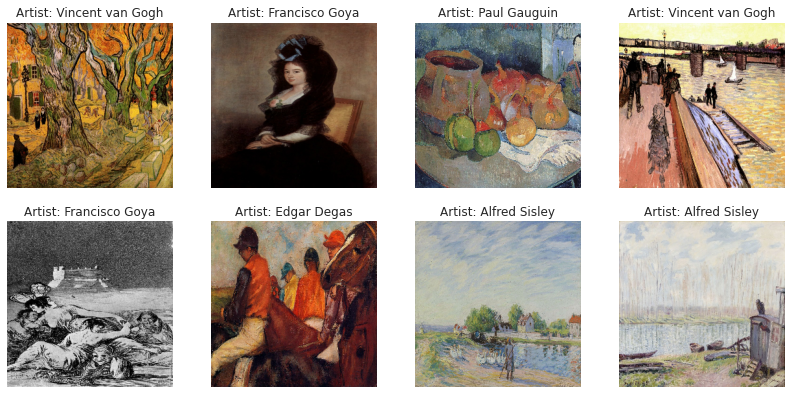

In [ ]:
plt.figure(figsize=(14, 14))
for images, labels in trainVisualization.take(1):
  for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Artist: " + classNames[labels[i]].replace('_', ' '))
    plt.axis("off")

In [ ]:
batchSize = 32
trainInputShape = (128, 128, 3)
numClasses = len(classNames)

Data Augmentation

In [ ]:
augmentedData = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255., 
                                   zoom_range = 0.1,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [ ]:
trainDataGenerator = augmentedData.flow_from_directory(directory=imageDir,
                                                    class_mode='categorical',
                                                    target_size=trainInputShape[0:2],
                                                    batch_size=batchSize,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=topArtistsName.tolist()
                                                   )
validDataGenerator = augmentedData.flow_from_directory(directory=imageDir,
                                                    class_mode='categorical',
                                                    target_size=trainInputShape[0:2],
                                                    batch_size=batchSize,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=topArtistsName.tolist()
                                                   )

Found 3181 images belonging to 10 classes.
Found 790 images belonging to 10 classes.


In [ ]:
trainBatch = trainDataGenerator.n//trainDataGenerator.batch_size
validBatch = validDataGenerator.n//validDataGenerator.batch_size
print("Total number of batches:\nTraining:", trainBatch, "\nValidation:", validBatch)

Total number of batches:
Training: 99 
Validation: 24


**Define Model**

Base model - ResNet50

In [ ]:
baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=trainInputShape)

for layer in baseModel.layers:
    layer.trainable = True

In [ ]:
X = baseModel.output
X = Flatten()(X)


X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)


X = Dense(256, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)


X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(numClasses, activation='softmax')(X)

model = Model(inputs=baseModel.input, outputs=output)

Training the model

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(generator=trainDataGenerator,
                              steps_per_epoch=trainBatch,
                              validation_data=validDataGenerator,
                              validation_steps=validBatch,
                              epochs=12,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduceLR],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=classWeights
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/12
99/99 [==============================] - 916s 9s/step - loss: 1.7295 - accuracy: 0.4182 - val_loss: 2.8517 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 2/12
99/99 [==============================] - 901s 9s/step - loss: 1.2989 - accuracy: 0.6380 - val_loss: 2.5468 - val_accuracy: 0.0651 - lr: 1.0000e-04
Epoch 3/12
99/99 [==============================] - 905s 9s/step - loss: 1.1269 - accuracy: 0.7247 - val_loss: 2.6497 - val_accuracy: 0.0885 - lr: 1.0000e-04
Epoch 4/12
99/99 [==============================] - 929s 9s/step - loss: 1.0167 - accuracy: 0.7764 - val_loss: 2.5482 - val_accuracy: 0.0938 - lr: 1.0000e-04
Epoch 5/12
99/99 [==============================] - 930s 9s/step - loss: 0.9152 - accuracy: 0.8184 - val_loss: 2.5707 - val_accuracy: 0.0404 - lr: 1.0000e-04
Epoch 6/12
99/99 [==============================] - 903s 9s/step - loss: 0.8212 - accuracy: 0.8431 - val_loss: 3.1815 - val_accuracy: 0.0729 - lr: 1.0000e-04
Epoch 7/12
99/99 [==============================] - 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

**Evaluating the model**

Plotting accuracy and loss

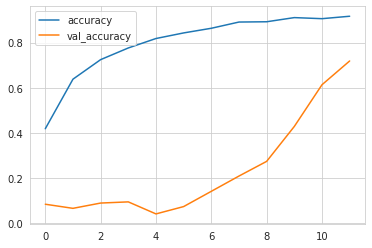

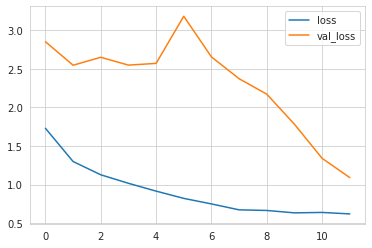

In [ ]:
historyFrame = pd.DataFrame(history.history)

historyFrame.loc[:, ['accuracy', 'val_accuracy']].plot()

historyFrame.loc[:, ['loss', 'val_loss']].plot()

Confusion Matrix

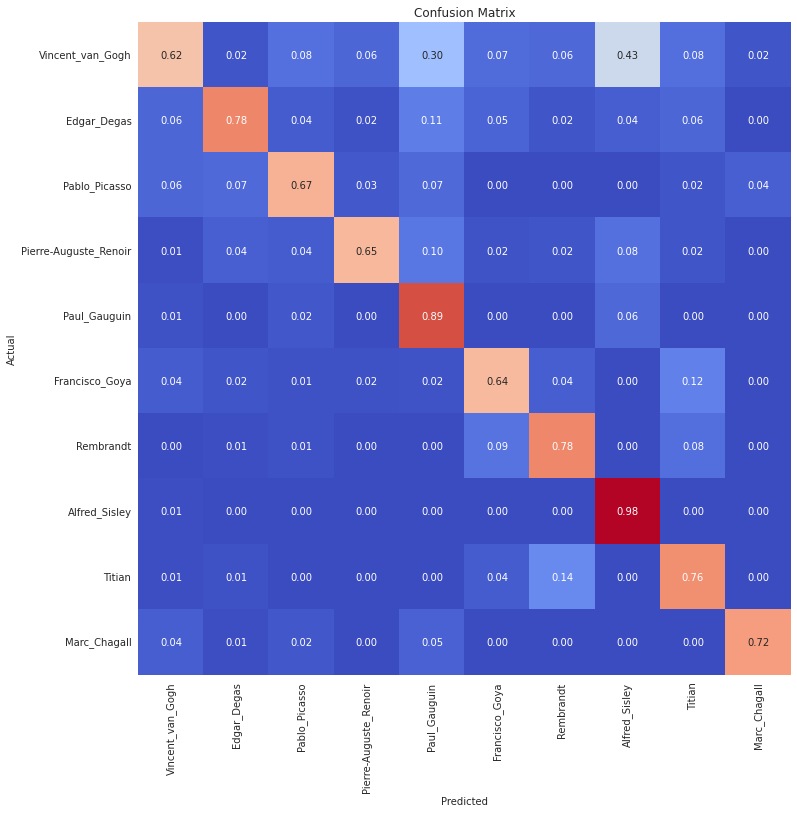

                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.73      0.62      0.67       170
          Edgar_Degas       0.81      0.78      0.79       135
        Pablo_Picasso       0.75      0.67      0.71        85
Pierre-Auguste_Renoir       0.84      0.65      0.74        66
         Paul_Gauguin       0.58      0.89      0.70        61
       Francisco_Goya       0.71      0.64      0.67        56
            Rembrandt       0.73      0.78      0.75        49
        Alfred_Sisley       0.62      0.98      0.76        49
               Titian       0.67      0.76      0.71        50
         Marc_Chagall       0.92      0.72      0.81        47

             accuracy                           0.73       768
            macro avg       0.74      0.75      0.73       768
         weighted avg       0.74      0.73      0.73       768



In [ ]:
tickLabels = topArtistsName.tolist()

def showClassficationReportGenerator(model, validDataGenerator, validBatch):
    predictionY, trueY = [], []
    for i in range(validBatch):
        (X,y) = next(validDataGenerator)
        predictionY.append(model.predict(X))
        trueY.append(y)
    
    predictionY = [subresult for result in predictionY for subresult in result]
    trueY = [subresult for result in trueY for subresult in result]

    trueY = np.argmax(trueY, axis=1)
    trueY = np.asarray(trueY).ravel()
    
    predictionY = np.argmax(predictionY, axis=1)
    predictionY = np.asarray(predictionY).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(12,12))
    confusionMatrix = confusion_matrix(trueY, predictionY, labels=np.arange(numClasses))
    confusionMatrix = confusionMatrix/np.sum(confusionMatrix, axis=1)
    sns.heatmap(confusionMatrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap="coolwarm", xticklabels=tickLabels, yticklabels=tickLabels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    classificationReport = classification_report(trueY, predictionY, labels=np.arange(numClasses), target_names=topArtistsName.tolist())
    print(classificationReport)

        
showClassficationReportGenerator(model, validDataGenerator, validBatch)

**Conclusion**


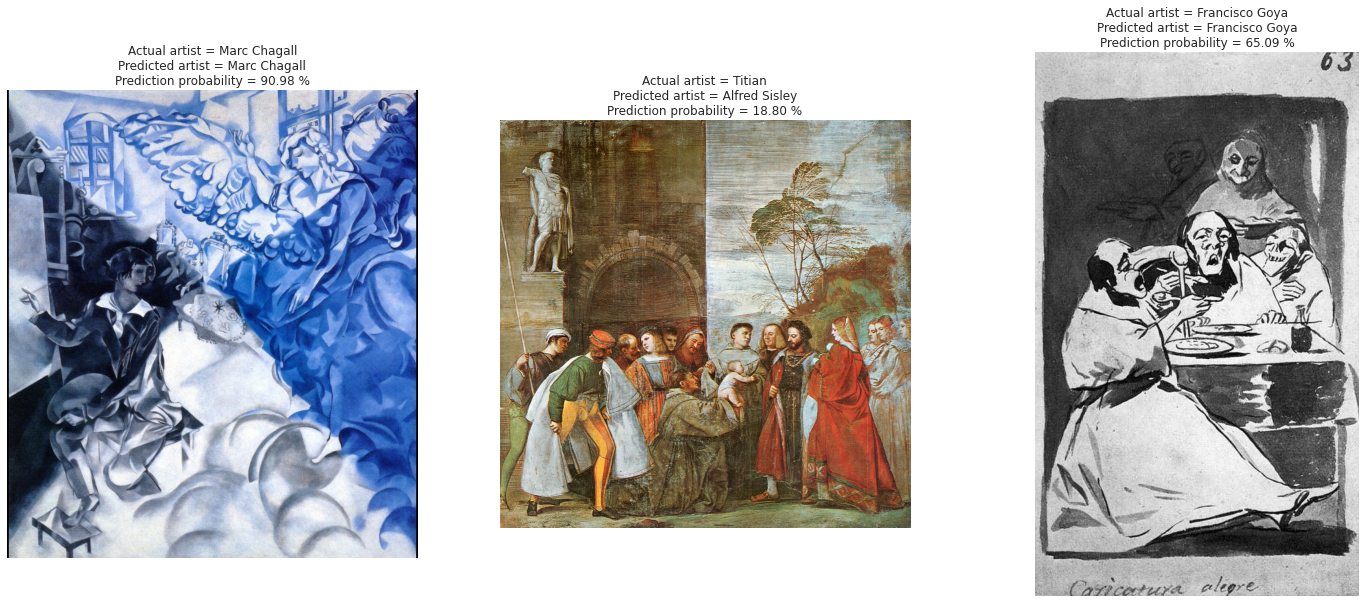

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    randomArtist = random.choice(topArtistsName)
    randomImage = random.choice(os.listdir(os.path.join(imageDir, randomArtist)))
    randomImageFile = os.path.join(imageDir, randomArtist, randomImage)

    testImage = image.load_img(randomImageFile, target_size=(trainInputShape[0:2]))

    testImage = image.img_to_array(testImage)
    testImage /= 255.
    testImage = np.expand_dims(testImage, axis=0)

    prediction = model.predict(testImage)
    predictionProbability = np.amax(prediction)
    predictionIndex = np.argmax(prediction)

    labels = trainDataGenerator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(randomArtist.replace('_', ' '), labels[predictionIndex].replace('_', ' '),
                        predictionProbability*100)

    axes[i].imshow(plt.imread(randomImageFile))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()